# Toxicity Classification of Parler Data 

## Background:
Since the Jan 6th attack on the capital, extremism is ever more important to detect and act on.
Parler chat data has been made available to various interested parties and has been archived for use.

The parler data is inherently unlabeled, thus different strategies can be employed to further the accurate classification of toxicity on this dataset.

## Approach

I'm opting for a semi-supervised learning process.

##### Pseudo-Labeling /Delta training
Taking the most confident model predictions to leak into the training set.. Though it is acknowledged there is bias in this approach.
##### Parler word vectors
Another approach is to evaluate how word vectors trained on parler data can improve classification.
##### Heuristics for predictions on unlabeled data
Additional Heuristics are needed to properly gauge/identify predictions on unlabeled parler data.


## Steps

##### Init Model
Initialize a model using labeled data from jigsaw-toxic-comment-classification
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview
##### Data Wrangling
Use work from d0nk to obtain a 2gb set of parler posts
https://github.com/d0nk/parler-tricks

Used modules from sbooeshaghi's git repo to process the 2GB sample
parler data https://github.com/sbooeshaghi/parlertrick/blob/main/parler.ipynb
##### Embeddings:
Combine parler, toxic tweet, and other data to create a common word vector
using GloVe from stanfordnlp
https://github.com/stanfordnlp/GloVe
##### Data Augmentation via text generation
Use textgenrnn made by minimaxir to generate toxic samples trained from test set according to specific labels
https://github.com/minimaxir/textgenrnn






Please reach out to medisp@icloud.com to collaborate

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
# os.environ['AUTOGRAPH_VERBOSITY'] = "0"
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
pd.set_option('expand_frame_repr', False)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib

In [5]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13709571582805183332
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2251253350
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1512653804423886702
physical_device_desc: "device: 0, name: GeForce GTX 780 Ti, pci bus id: 0000:03:00.0, compute capability: 3.5"
]


In [6]:
import keras
print(tf.__version__)
print(keras.__version__)

2.4.1
2.3.1


### Set attributes and load data

In [17]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 50      # embedding dimensions for word vectors (word2vec/GloVe)
#GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

train = pd.read_csv('labeled_data/train.csv' ) # , header=0, sep=',', quotechar='"')
test = pd.read_csv('labeled_data/test.csv' ) # , header=0, sep=',', quotechar='"')
labels_test = pd.read_csv('labeled_data/test_labels.csv' ) # , header=0, sep=',', quotechar='"')
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

y = train[labels].values
comments_train = train['comment_text']
comments_train = list(comments_train)

# According to https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/55975
# labels of -1 weren't used in scoring and are not actually labels

labels_test = labels_test[(labels_test[labels] != -1).any(axis=1)]
test = test.iloc[labels_test.index]
test_y = labels_test[labels].values

### Text processing

In [8]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'\W+',' ',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output)

In [9]:
clean_text('Could not be more clear',False)

'could not be more clear'

In [ ]:
# texts = [] 

# for line in comments_train: 
#     texts.append(clean_text(line))
# print('Sample data:', texts[1], y[1])

### Save processed text
Takes an hour or so

In [ ]:
# with open('text_files/train_cleansed_text.txt', 'w', encoding="utf-8") as filehandle:
#     filehandle.writelines("%s\n" % line for line in texts)

In [10]:
# read in saved cleansed training test as a list
# define empty list
texts = []
# open file and read the cleansed texts
with open('text_files/train_cleansed_text.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()
    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]
        # add item to the list
        texts.append(current_place)

### Create Tokenizers and Sequences

Using a word level tokenizer 

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 207546


### Pad Sequences and view tensor shapes

In [12]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


### Shuffle Data

In [13]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]
pred_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### Split Training and Validation data

In [14]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of samples in each class:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of samples in each class:
training:  [12189  1268  6702   381  6273  1138]
validation:  [3105  327 1747   97 1604  267]


In [15]:
print('Tokenized sentences: \n', data[74373])
print('One hot label: \n', labels[74373])

Tokenized sentences: 
 [ 1676     1   287  2655 32191    50     7   142  1514    98  2639   638
   604    39 26000   184     1   198    90   720  2400    47  2371   217
 22119   162   558    84   179    34    89 15992  1062  2538  5923  2039
  2059  3112 20146   874   362  1028   918  3120  7271  1514   217     7
  3196   217     8    63 41135   832   282  1436  1604  2016 14563  1264
   295  3536   133    56   861  2738  2738     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

### Word Vectors
set initial baseline by using twitter 200B word vectors

Observe for improvement by using parler + train + test data

More generalizable model using wordvecs created via glove on parler data + train + test

In [18]:
# Using Twitter 200B word vectors
embeddings_index = {}
#GLOVE_DIR = "glove_vectors/glove.twitter.27B."+str(EMBEDDING_DIM)+"d.txt"
GLOVE_DIR = "glove_vectors/glove.parlertoxic.50M."+str(EMBEDDING_DIM)+"d.txt"
f = open(GLOVE_DIR, errors = 'ignore' , encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove_vectors/glove.parlertoxic.50M.50d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


### Create Model

The model uses an input layer bounded by sequence length of the texts. Issues may arise when long text samples are sent for prediction.

The embedding layer is initialized via weights from word vectors

LSTM Cell with 60 units with return sequences = True, returning values from each time/sequence step.

Max pooling to capture most important time step

Dropout layer

Dense layer with rectified linear unit activation

Dropout layer 2

Sigmoid final layer to give probabilities of each class (6)


TODO: 
- Skip connections? 
- Lasso(l1) or Ridge (l2) regularization
- dropout tuning
- 2 different embeddings with concatenation before LSTM

In [19]:
#  input --> embedding --> lstm 60 cell --> pooling --> dropout --> dense --> drop --> final dense
REG_CONSTANT = 0.0001
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, 
         return_sequences=True,
         name='lstm_layer',
         kernel_regularizer=l2(REG_CONSTANT), 
         recurrent_regularizer=l2(REG_CONSTANT),
         bias_regularizer=l2(REG_CONSTANT))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid")(x)

### Compile Model

Instantiating model with input and output
compiling model using binary cross entropy loss, and adam optimizer

TODO: ADAM learning rate + learning rate decay


In [20]:
model = Model(sequence_input, preds)
opt = Adam(learning_rate=0.001)
model.compile(loss = 'binary_crossentropy',
             optimizer=opt,
             metrics = ['accuracy'])

In [21]:
import keras
import pydot
import pydotplus
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot


### Model Visualization

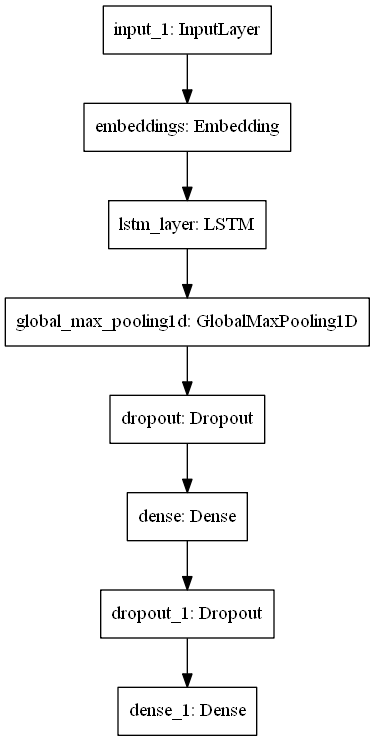

In [22]:
plot_model(model)


In [23]:
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 50)           10377350  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           26640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

### Keras callbacks mid epoch

In [24]:
filepath = "models/toxic-classifier/tc-gpu-v0.05-200emb-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='accuracy',
                             factor=0.2,
                             patience=2,
                             min_lr=0.0001)

early_stopping = EarlyStopping(monitor='accuracy',
                              patience=6
                              )

### Execute Training

In [25]:
print('Training progress:')
history = model.fit(x_train, 
                    y_train, 
                    epochs = 30, 
                    batch_size=1024, 
                    validation_data=(x_val, y_val), 
                    callbacks= [reduce_lr,
                               early_stopping])

Training progress:
Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/125 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.4259WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A9BA94BD90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTO

In [26]:
model.save('models/toxic-classifier/tc-gpu-v0.06-50emb.hdf5')

### Evaluation

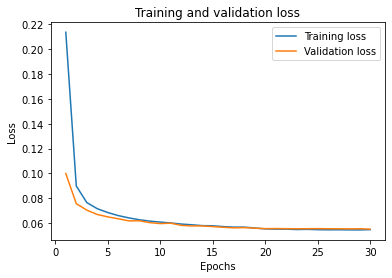

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();


#### Process and encode test input

In [ ]:
# test_cleansed_text = list(test.apply(lambda x: clean_text(x.comment_text), axis=1))
# with open('text_files/test_cleansed_text.txt', 'w', encoding="utf-8") as filehandle:
#     filehandle.writelines("%s\n" % line for line in test_cleansed_text)

In [28]:
# Reading in saved test cleansed text as a list
test_cleansed_text = []
# open file and read the cleansed texts
with open('text_files/test_cleansed_text.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()
    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]
        # add item to the list
        test_cleansed_text.append(current_place)

In [29]:
encoded_input = tokenizer.texts_to_sequences(test_cleansed_text)

In [30]:
enc_data = pad_sequences(encoded_input, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [31]:
test_preds = model.predict(enc_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### Compute stats metrics

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

def calc_auc(y_true,y_pred):
     return np.mean([roc_auc_score(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])
    
def calc_loss(y_true, y_pred):
    return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])

def roc_auc_score_multiclass(y_true, y_pred, average = "macro"):
    roc_auc_dict = {}
  # iterate through labels
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    for i,label in enumerate(labels):
        #using the sklearn metrics method to calculate the roc_auc_score
        try:
            roc_auc = roc_auc_score(y_true[:,i], y_pred[:,i], average = average)
        except:
            roc_auc = 0
        roc_auc_dict[label] = roc_auc

    return roc_auc_dict

In [33]:
print("AUC      {:10.4f}".format(calc_auc(test_y,test_preds)))
print("Log Loss {:10.4f}".format(calc_loss(test_y,test_preds)))
roc_auc_score_multiclass(test_y,test_preds)

AUC          0.9703
Log Loss     0.0748


{'toxic': 0.9565937800393218,
 'severe_toxic': 0.9883905440754359,
 'obscene': 0.9722713152135012,
 'threat': 0.9726481264693136,
 'insult': 0.9605755509212772,
 'identity_hate': 0.9711074442420214}

In [34]:
model.evaluate(enc_data,test_y)

2000/2000 [==============================] - 20s 10ms/step - loss: 0.0782 - accuracy: 0.9976


[0.07817086577415466, 0.9976085424423218]

### Per Class Stats

In [35]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(y_true, y_pred):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    y_true (np.array): a multi-class array of the true values with shape (len(y_true),num_classes)
    @params    y_pred (np.array): a multi-class array of predicted probabilities with shape (len(y_true), num_classes)
    """
    fpr = {}
    tpr = {}
    threshold = {}
    roc_auc = {}
    accuracy = {}
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    for i,label in enumerate(labels):
        fpr[label], tpr[label], threshold[label] = roc_curve(y_true[:,i], y_pred[:,i])
        print('Stat Metrics: {}'.format(label))
        roc_auc[label] = auc(fpr[label], tpr[label])
        print(f'AUC: {roc_auc[label]:.4f}')

        # Get accuracy over the test set
        y_delt = np.where(y_pred[:,i] >= 0.5, 1, 0)
        accuracy = accuracy_score(y_true[:,i], y_delt)
        print(f'Accuracy: {accuracy*100:.2f}%')

        # Plot ROC AUC
        plt.title('Receiver Operating Characteristic: {}'.format(label))
        plt.plot(fpr[label], tpr[label], 'b', label = 'AUC = %0.2f' % roc_auc[label])
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

Stat Metrics: toxic
AUC: 0.9566
Accuracy: 92.11%


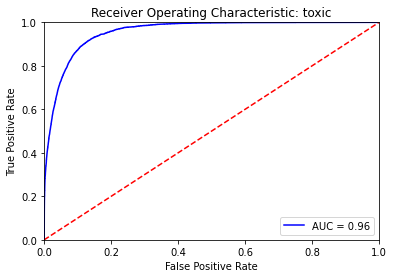

Stat Metrics: severe_toxic
AUC: 0.9884
Accuracy: 99.43%


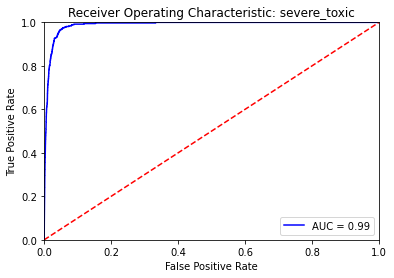

Stat Metrics: obscene
AUC: 0.9723
Accuracy: 96.03%


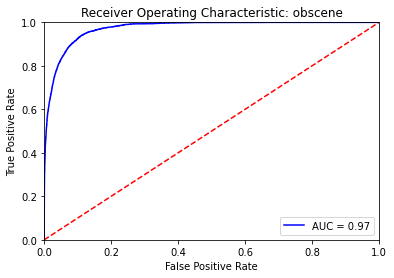

Stat Metrics: threat
AUC: 0.9726
Accuracy: 99.67%


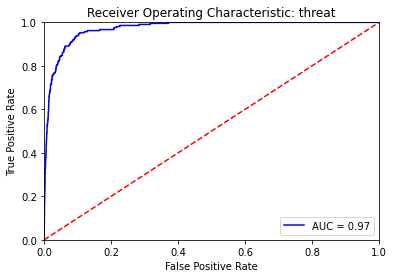

Stat Metrics: insult
AUC: 0.9606
Accuracy: 95.49%


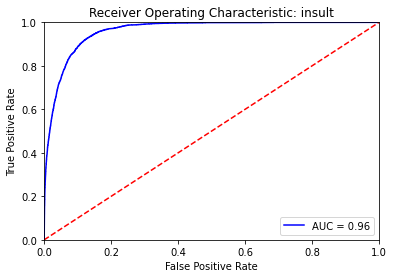

Stat Metrics: identity_hate
AUC: 0.9711
Accuracy: 98.90%


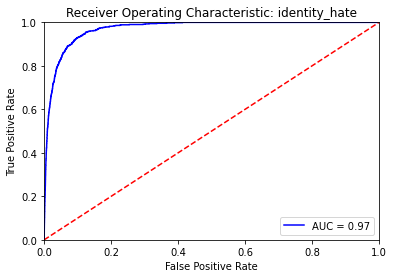

In [36]:
evaluate_roc(test_y,test_preds)

### Loading Parler Data

In [37]:
parler_df = pd.read_csv('out.zip', compression='zip', header=0, sep=',', quotechar='"')

In [94]:
from pandas_profiling import ProfileReport

In [96]:
profile = ProfileReport(parler_df, title="Parler Profiling Report", minimal=True)

In [97]:
#profile.to_widgets()
# takes 6 mins or so
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
parler_df = parler_df.dropna()
parler_df = parler_df.drop_duplicates(subset=['post_text'])
#df_inf = df_inf.reset_index(drop=True)

In [39]:
parler_df[['post_text','post_impressions']].sample(4)

,post_text,post_impressions
846594,Iranian American Patriots joined the march today in DC.Down with the Islamic Republic in Iran.,13.00
204449,Trump’s “explosions of bullshit” clip #explosionsofbullshit,"78,241.00"
1545548,One wonders what the media's take is over Kent State (college campus) and the Boston Massacre (public square) in the context of unarmed civilians in the Capital Building encountering similar armed federal employees.,64.00
551140,I love him 😍 he’s a great man !,"2,844.00"


In [ ]:
df_inf = parler_df.sort_values(by=['post_impressions'], ascending=False, na_position='last')[:20000]
df_inf = df_inf.reset_index(drop=True)

In [40]:
# Cleanse post text
# cleansed_post_text = df_inf.apply(lambda x: clean_text(x.post_text), axis=1)

# read in saved cleansed parler text as a list

cleansed_parler_text = []
# open file and read the cleansed texts
with open('text_files/cleansed_parler.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()
    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]
        # add item to the list
        cleansed_parler_text.append(current_place)

In [41]:
len(cleansed_parler_text)

47691

In [42]:
print('Sample inference data:', cleansed_parler_text[6])

Sample inference data:  america home brave america home strong begun fight want push us dems doomed freedom americabecausefuckyou warriors fight dosomething nofear win


In [43]:
encoded_input = tokenizer.texts_to_sequences(cleansed_parler_text)

In [45]:
enc_data = pad_sequences(encoded_input, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [46]:
inf_results = model.predict(enc_data)

### Adding Prediction Labels to parler df

In [47]:
pred_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [48]:
parler_df = parler_df.reset_index(drop=True)
for i, result_array in enumerate(inf_results):
    for j,label in enumerate(pred_labels):
        parler_df.at[i,label] = result_array[j]
        #df_inf.set_value(i,label , result_array[j])

### Eyeballing Results of inference

Warning: The text in this data contains graphic content and may be upsetting to some people.
In light of this, sorting by least toxic of the labels in order to spot false positives may be a more palatable strategy

In [49]:
view = parler_df.sort_values(by=pred_labels, ascending=True, na_position='last')[['post_text','post_impressions','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']][:200]

In [51]:
view.sample(3)

,post_text,post_impressions,toxic,severe_toxic,obscene,threat,insult,identity_hate
16390,And that's ok either way.I prefer clarity on position. 💯🎯,15.00,0.00,0.00,0.00,0.00,0.00,0.00
22572,Our team is in Georgia. They took a little walk. They found shredded ballots in Dell boxes. Police came as well. They wanted to confiscate phones with evidence.Here is just the first few photos. @Name Hidden @LLinWood @Name Hidden @Project_Veritas,321.00,0.00,0.00,0.00,0.00,0.00,0.00
10339,"12/ AUDIO: The theft of the election was orchestrated by Stephan Serafini, a 20-year foreign service officer. Stephan coordinated with General Claudio Graziano, a board member of Leonardo. Italian intelligence provided us with documents, calls, & photos of CIA agents involved.","15,465.00",0.00,0.00,0.00,0.00,0.00,0.00


### Determining a threshold to create the best separation 

In [52]:
parler_threshold = parler_df[(parler_df[pred_labels] <= 0.01).all(axis=1)]

In [53]:
parler_threshold[["post_text"]+pred_labels].sample(4)

,post_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
35616,I cannot imagine a way in which this person did not bring this upon themselves 💅🏿💅🏿💅🏿💅🏿💅🏿💅🏿💅🏿,0.01,0.00,0.00,0.00,0.00,0.00
18054,"My, my, my. Isn't this interesting.#themoreyouknow #factsmatter #news #walkinverse",0.00,0.00,0.00,0.00,0.00,0.00
17079,"I havn’t seen many MAGA dressed this way, however...",0.01,0.00,0.00,0.00,0.00,0.00
1886,"We all know what happened, the world knows what happened and today we find out what will be done about it. I pray for peace and safety over all #patriots but stand prepared for war.",0.01,0.00,0.00,0.00,0.00,0.00


In [ ]:
parler_threshold.to_csv('pandas_dfs/parler_threshold.csv', index = True, sep=',', quotechar='"')

In [ ]:
parler_threshold = pd.read_csv('pandas_dfs/parler_threshold.csv', index_col=0, sep=',', quotechar='"')

### Comments
A problem with this approach arises when missed classifications that are egregiously threatening aren't propagated to the sample.

A way to check this is to create a hold-out set from this, and train on the remainder.
We return to this hold-out set with a model trained on that remainder.
We can then check if the model was able to learn more from this body of toxic text to flag things that are missed.
Setting a strong threshold will let us eyeball any missed predictions.


In [54]:
training_leakage = parler_df.drop(parler_threshold.index)

In [55]:
training_leakage[["post_text"]+pred_labels].sample(4)

,post_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
10853,"ANTIFA Will Wear MAGA Gear at Jan 6 Rally!!!, 3437",0.04,0.00,0.01,0.00,0.01,0.00
30362,"Beauty matters. Aesthetics matter. Making something beautiful shows respect to yourself and others. That where you are and who you are matters. “Beauty is an ultimate value—something that we pursue for its own sake, and for the pursuit of which no further reason need be given. Beauty should therefore be compared to truth and goodness, one member of a trio of ultimate values which justify our rational inclinations.” - Roger Scruton",0.01,0.00,0.00,0.00,0.00,0.00
31973,Get in her face,0.65,0.01,0.17,0.01,0.25,0.02
7842,That’s a Hammer And sickle Tatoo on his hand ✋ Obviously this is BLM / Antifa,0.51,0.01,0.15,0.01,0.21,0.02


### ~5k new data points using threshold of 0.5 

Using this set, we will split 1k as holdout2 and use 4k for training


In [56]:
toxic_parler_subset = training_leakage[(training_leakage[pred_labels] >= 0.5).any(axis=1)]

In [57]:
len(toxic_parler_subset)

4533

In [58]:
toxic_parler_train = toxic_parler_subset[["post_text"]+pred_labels]

In [61]:
for label in pred_labels:
    toxic_parler_train[label].loc[toxic_parler_train[label] > 0.5] = 1
    toxic_parler_train[label].loc[toxic_parler_train[label] < 0.5] = 0

C:\Users\medisp\Miniconda3\envs\keras\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\medisp\Miniconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\medisp\Miniconda3\envs\keras\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._

In [62]:
toxic_parler_train.sample(3)

,post_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
13788,Are you fucking kidding me? You ppl are going to let them STEAL GEORGIA TOO?,1.00,0.00,1.00,0.00,1.00,0.00
26327,Looking forward to “White” Athletes kneeling in protest for the murder of an unarmed “White” women by the police! 🤬🤬🤬🤬🤬🤬🤬🤬🤬😂,1.00,0.00,0.00,0.00,0.00,0.00
43405,"The lunatics, retards, & insane are now in control. Arm yourselves. God help us.",1.00,0.00,0.00,0.00,0.00,0.00


In [63]:
parler_train = list(toxic_parler_train.apply(lambda x: clean_text(x.post_text), axis=1))

In [64]:
parler_y = toxic_parler_train[pred_labels].values

In [66]:
parler_train_append = parler_train[:4000]

In [67]:
parler_y_append = parler_y[:4000]

In [68]:
parler_y_append.shape

(4000, 6)

In [69]:
parler_x_holdout = parler_train[4000:]

In [70]:
parler_y_holdout = parler_y[4000:]

In [71]:
parler_y_holdout.shape

(533, 6)

### Combining texts with parler_train, y with parler_y

In [72]:
len(texts)

159571

In [73]:
# 3 duplicates
texts.extend(parler_train_append)
texts.extend(parler_train_append)
texts.extend(parler_train_append)

In [74]:
len(texts)

171571

In [75]:
y_list = list(y)
y_list.extend(list(parler_y_append))
y_list.extend(list(parler_y_append))
y_list.extend(list(parler_y_append))

In [76]:
len(y_list)

171571

In [77]:
y1 = np.array(y_list)

In [78]:
y1.shape

(171571, 6)

### Copied Code from Above to retrain

In [79]:
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 207546


In [80]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y1.shape)

Shape of data tensor: (171571, 200)
Shape of label tensor: (171571, 6)


In [81]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y1[indices]

In [82]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of samples in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of samples in each category:
training:  [21819.  1318. 10391.   370.  9425.  1108.]
validation:  [5475.  322. 2570.  108. 2394.  297.]


In [83]:
# Using Twitter 200B word vectors
embeddings_index = {}
#GLOVE_DIR = "glove_vectors/glove.twitter.27B."+str(EMBEDDING_DIM)+"d.txt"
GLOVE_DIR = "glove_vectors/glove.parlertoxic.50M."+str(EMBEDDING_DIM)+"d.txt"
f = open(GLOVE_DIR, errors = 'ignore' , encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

#  input --> embedding --> lstm 60 cell --> pooling --> dropout --> dense --> drop --> final dense

REG_CONSTANT = 0.0001
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, 
         return_sequences=True,
         name='lstm_layer',
         kernel_regularizer=l2(REG_CONSTANT), 
         recurrent_regularizer=l2(REG_CONSTANT),
         bias_regularizer=l2(REG_CONSTANT))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid")(x)

Loading GloVe from: glove_vectors/glove.parlertoxic.50M.50d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [84]:
model_parler = Model(sequence_input, preds)
opt = Adam(learning_rate=0.001)
model_parler.compile(loss = 'binary_crossentropy',
             optimizer=opt,
             metrics = ['accuracy'])

In [85]:
model_parler.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 50)           10377350  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           26640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

In [86]:
reduce_lr = ReduceLROnPlateau(monitor='accuracy',
                             factor=0.2,
                             patience=2,
                             min_lr=0.0001)

early_stopping = EarlyStopping(monitor='accuracy',
                              patience=6
                              )
print('Training progress:')
history = model_parler.fit(x_train, 
                    y_train, 
                    epochs = 30, 
                    batch_size=1024, 
                    validation_data=(x_val, y_val), 
                    callbacks=[reduce_lr,
                               early_stopping])
model_parler.save('models/toxic-classifier/parler-classifier-gpu-v0.06-50emb.hdf5')


Training progress:
Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
134/135 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.5923WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A9BD40DA60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTO

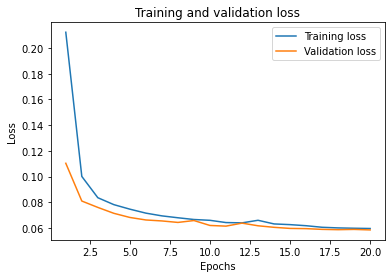

In [87]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();


In [89]:
# Reading in saved test cleansed text as a list
test_cleansed_text = []
# open file and read the cleansed texts
with open('text_files/test_cleansed_text.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()
    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]
        # add item to the list
        test_cleansed_text.append(current_place)

In [90]:

encoded_parler_x_holdout = tokenizer.texts_to_sequences(parler_x_holdout)
enc_parler_x_holdout = pad_sequences(encoded_parler_x_holdout, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
parler_holdout_preds = model_parler.predict(enc_parler_x_holdout)

encoded_input = tokenizer.texts_to_sequences(test_cleansed_text)
enc_data = pad_sequences(encoded_input, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
test_preds = model_parler.predict(enc_data)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [91]:
print("AUC      {:10.4f}".format(calc_auc(test_y,test_preds)))
print("Log Loss {:10.4f}".format(calc_loss(test_y,test_preds)))
roc_auc_score_multiclass(test_y,test_preds)

AUC          0.9635
Log Loss     0.0813


{'toxic': 0.9543028591080357,
 'severe_toxic': 0.9866632538363178,
 'obscene': 0.9716118713414889,
 'threat': 0.9537461509195542,
 'insult': 0.9586071089588393,
 'identity_hate': 0.9563630060095825}

#### Everything seems to be toxic in this set

so only one class was found, hence inability to calculate metrics

In [93]:
#print("AUC      {:10.4f}".format(calc_auc(parler_y_holdout,parler_holdout_preds)))
#print("Log Loss {:10.4f}".format(calc_loss(parler_y_holdout,parler_holdout_preds)))
roc_auc_score_multiclass(parler_y_holdout,parler_holdout_preds)

{'toxic': 0,
 'severe_toxic': 0,
 'obscene': 0.9882740330174624,
 'threat': 0,
 'insult': 0.9844424402499516,
 'identity_hate': 0}

### Time to test this model on the parler-threshold set to see what new predictions arise

As a reminder, parler threshold dataset was a subset of parler_df that had no scores above 0.01.

Anything we see above this confirms more identification, and we can sort by descending to observe

In [98]:
cleansed_threshold_text = parler_threshold.apply(lambda x: clean_text(x.post_text), axis=1)
encoded_threshold_input = tokenizer.texts_to_sequences(list(cleansed_threshold_text))
enc_threshold_data = pad_sequences(encoded_threshold_input, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
inf_threshold_results = model_parler.predict(enc_threshold_data)

In [99]:
parler_threshold_reanalyze = parler_threshold.reset_index(drop=True)

for i, result_array in enumerate(inf_threshold_results):
    for j,label in enumerate(pred_labels):
        parler_threshold_reanalyze.at[i,label] = result_array[j]
        #df_inf.set_value(i,label , result_array[j])

In [100]:
view = parler_threshold_reanalyze.sort_values(by=pred_labels, ascending=False, na_position='last')[["post_text"]+pred_labels][:200]

In [103]:
view[:25]

,post_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
4855,#MAGA @magamarch ECHO For PRESIDENT TRUMP 🇺🇸🇺🇸#trump #millionmagamarch #Army #usafirst #military #freedom #freedomofspeech #bestpresident #trump #trumpforever #goverment #covid #badtime #fraudelection #fraudvotes #staystrong #usapeople #usaparler #parler #familyvalues #merrychristmas #maga2020 #trumptrain #redline #storngamerica #TRUMPSUPPORTERS #FREEDOM #freedomodspeech #trump #trump2020 #presidenttrump #parler #usaparler #politics #usafirst #america #keepamericagreat #news #election #memes #maga #covid #usa #america #congress #politicalmemes #donaldtrump #vote #coronavirus #government #love #political #freedom #meme #president #keepamericagreat #election #keepthefaith #freedom #freedomofspeech #freedomfighters #trumpleadership #godblesspresidenttrump #trumpfollowers #magapower,0.90,0.00,0.00,0.00,0.00,0.00
191,What better way to ROB Patriots of the headlines than to stage ANTIFA people As Trump supporters and storm the capital & if you look at the photo that I'm submitting these are not Trump folks,0.84,0.00,0.00,0.00,0.00,0.00
2131,#DonaldTrump #trump #maga #trumptrain #bidencheated #parler #election2020 #donaldjtrump #memes #COVID19 #dominion #censorship #liberty #stopthesteal #walkaway #freedom #wakeupamerica #republican,0.79,0.00,0.00,0.00,0.00,0.00
4660,💖⭐️💫💝🌟💖⭐️💫💝🌟⭐️💖🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸Congratulations President Trump on Winning the 2020 Election in a Massive Landslide! Trump won Bigly! Pass it on! 🇺🇸⭐️🇺🇸🌟🇺🇸⭐️🇺🇸🌟🇺🇸⭐️🇺🇸🌟#trumpwon2020 #gijoevets #co4djt #cocass2,0.74,0.00,0.00,0.00,0.00,0.00
4845,If you voted for Donald Trump ECHO🇺🇸Follow me if you are Trump supporter @seantherepublican 🇺🇸ECHO if you think Dems cheated on this ELECTION♻️♻️🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸#TRUMP #TRUMP2020 #maga #whitehouse #trumptrain #donaldtrump #presidenttrump #conservative #meme #news #gop #covid19 #qanon #thegreatwakening #blm #teamtrump #patriotprayer #proudboys #wwg1wga #q #qarmy #deepstate #keepamericagreat #makeamericagreatagain #scotus #WakeUpAmerica #FoxNews #keepamericagreat #China #Antifa #Plandemic #JoeBiden #presidenttrump #VoterFraud #truth #presidenttrump #teamtrump #womenfortrump #trumpsupporters #realdonaldtrump #trusttheplan #bikersfortrump #trumppence2020 #trumprally #trumpmemes #trumpwon #latinosfrotrump #blackfortrump #inGodwetrust #donaldjtrump #trumparmy #trumppence #FightBack #StopTheSteal #Canada #SCOTUS,0.71,0.00,0.00,0.00,0.00,0.00
6161,They’re pulling away!!!!! @KLoeffler @SenDavidPerdueGA #senate #congress #gop #trump #january6th #trump2020 #georgia #georgiasenaterunoff #dominion #electionfraud #america #usa #catholic,0.67,0.00,0.00,0.00,0.00,0.00
3798,President Trump 🇺🇸🇺🇸#Army #usafirst #military #freedom #freedomofspeech #bestpresident #trump #trumpforever #goverment #covid #badtime #fraudelection #fraudvotes #staystrong #usapeople #usaparler #parler #familyvalues #merrychristmas #maga2020 #trumptrain #redline #storngamerica #TRUMPSUPPORTERS #FREEDOM #freedomodspeech #trump #trump2020 #presidenttrump #parler #usaparler #politics #usafirst #america #keepamericagreat #news #election #memes #maga #covid #usa #america #congress #politicalmemes #donaldtrump #vote #coronavirus #government #love #political #freedom #meme #president #keepamericagreat #election #keepthefaith #freedom #freedomofspeech #freedomfighters #trumpleadership #godblesspresidenttrump #trumpfollowers,0.66,0.00,0.00,0.00,0.00,0.00
1680,#Trump #Trump #SupremeCourt #Constitution #Parler #ParlerKSA #military #Guns #DemCheats #Trump2020 #MAGA2020 #news #freedom #trumptrain #kag #maga #makeamericagreatagain 🇺🇸 🇺🇸,0.66,0.00,0.00,0.00,0.00,0.00
971,#TRUMP #trumptrain #donaldtrump #presidenttrump #conservative #meme #news #gop #covid19 #qanon #thegreatawakening #blm #teamtrump #patriotprayer #proudboys #wwg1wga #q #qarmy #prolife #deepstate #keepamericagreat #makeamericagreatagain #votetrump2020 #godblessamerica #bidencrimefamily #arizona #kag2020 #pennsylvania #stopthesteal #fraud #truth #Election2

### An unintended result
- We clearly see False Positives, Additional review is necessary to apply other heuristics of toxicity to determine if there are False Negatives.

- This model is flagging anything related to Trump loyalism as toxicity, which is an incorrect label at best and potentially offensive at worst.

- This seemed to have only found hashtags and common vernacular that were merely associated with toxicity that other users posted. The Model weighted these in determining toxicity.




## WIP:
- Tuning of new model with additional data - drastically reduced test set performance
- Evaluation of parler-threshold holdout set of ~21k records. Testing hypothesis of whether additional toxic components are found
- Use of textgenrnn for further data augmentation of test set

### text gen

In [ ]:
from tensorflow.keras import *

In [ ]:
from textgenrnn import textgenrnn

In [ ]:
df2 = pd.read_csv('out.zip', compression='zip', header=0, sep=',', quotechar='"')

In [ ]:
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset=['post_text'])
# cleansed_post_text = df2.apply(lambda x: clean_text(x.post_text), axis=1)


In [ ]:
# define empty list
cleansed_post_text = []
# open file and read the cleansed texts
with open('text_files/cleansed_parler.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()

    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]

        # add item to the list
        cleansed_post_text.append(current_place)
        

In [ ]:
textgen = textgenrnn()

In [ ]:
textgen.train_on_texts(list(cleansed_post_text),num_epochs=50, batch_size=512)

In [ ]:
textgen.save('models/parler-hybridgpu-V0.1.hdf5')

In [ ]:
textgen.load("models/parler-gen-V0.1.hdf5")

textgen.generate()

In [ ]:
for i in range(3,20):
    temp = (i)*0.05
    print('Generating samples at temp: ', temp)
    textgen.generate(1, temperature=temp, max_gen_length =300  )